In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from langchain_ollama import OllamaLLM
from langchain_core.prompts import ChatPromptTemplate
import ast



# plt.style.use('dark_background')

filename='vehicles.csv'
df=pd.read_csv(filename,parse_dates=['posting_date'])


In [2]:
df=df.drop(columns=['county','state','lat','long'])
# filters
# df = df[df['posting_date'] > 2019]
df = df[df['year'] > 1999]
df = df[df['odometer'] < 150000]
df = df[(df['condition'] == 'excellent') | (df['condition'] == 'good')]
df = df[(df['transmission'] == 'manual') | (df['transmission'] == 'automatic')]
manufacturer_list=['subaru','bmw','toyota','ford','lexus','gmc']
df = df[df['manufacturer'].isin(manufacturer_list)]
# drop rows where 'description' is missing
df=df.dropna(subset=['description'])
df = df.replace({np.nan: None})
df['year'] = df['year'].astype(int)

KeyboardInterrupt: 

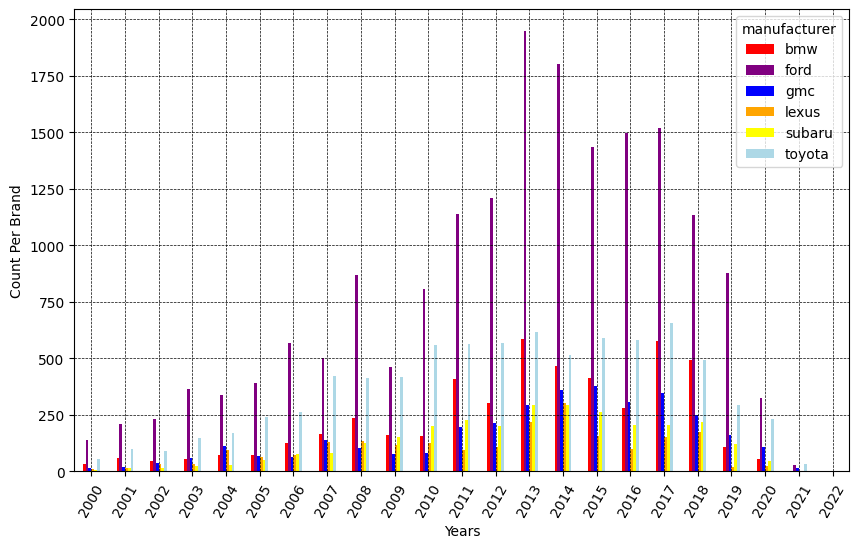

In [ ]:
df_pivot = pd.pivot_table(
		df,
		values="model", # value
		index="year", # row
		columns="manufacturer", 
		aggfunc='count'
	)	

colors=['red', 'purple', 'blue', 'orange','yellow','lightblue']
ax = df_pivot.plot(kind="bar",color=colors,figsize=(10,6))
fig = ax.get_figure()
color1='black'
ax.set_xlabel("Years",color=color1)
ax.set_ylabel("Count Per Brand",color=color1)
plt.xticks(rotation=60,color=color1)
plt.yticks(color=color1)
plt.title('Car Brands per year')

plt.grid(color = color1, linestyle = '--', linewidth = 0.5)

plt.show()

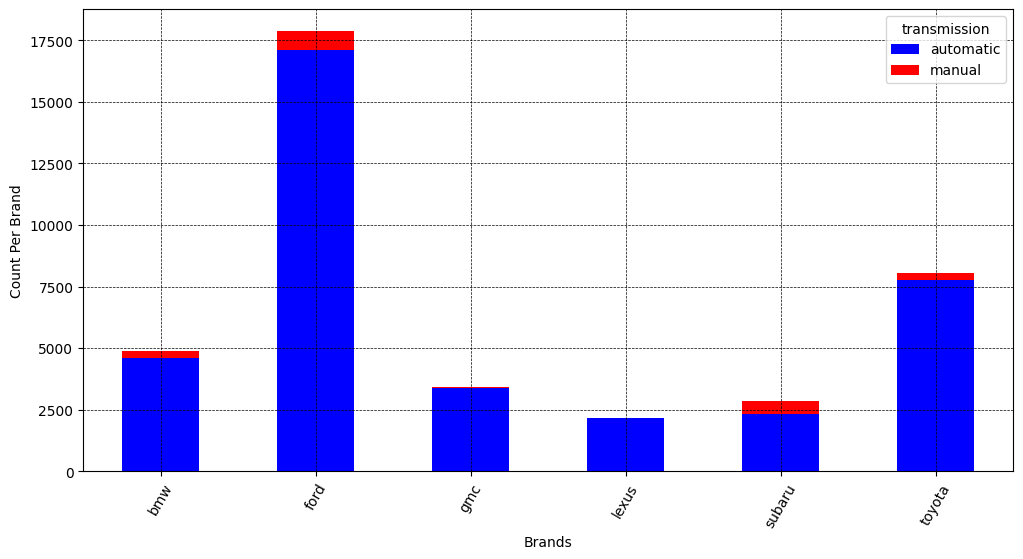

In [ ]:
# manufacturer_list=['subaru','bmw','toyota']
# df = df[df['manufacturer'].isin(manufacturer_list)]
# cars_manual=df[df['transmission']=='manual']
# cars_automatic=df[df['transmission']=='automatic']

# dfg = df.groupby(['manufacturer'])['transmission'].count()

dfp=df.pivot_table(index = 'manufacturer', columns = 'transmission',values='id', aggfunc='count' )

# dfp=df.groupby(['manufacturer','transmission']).count()

colors=['blue', 'red']
ax = dfp.plot(kind="bar",color=colors,stacked=True,figsize=(12,6))
fig = ax.get_figure()

ax.set_xlabel("Brands",color=color1)
ax.set_ylabel("Count Per Brand",color=color1)
plt.xticks(rotation=60,color=color1)
plt.yticks(color=color1)
plt.title('Car Brands per year')


plt.grid(color = color1, linestyle = '--', linewidth = 0.5)


plt.show()



## Here is a simpler example on how we can get the missing values with Ollama
### This approach is used to iterate through each row 

In [ ]:
# description
context='''
Looking to sell my 2006 Subaru Impreza hatchback. The good: engines only got 97,000 miles on it, runs strong, shifts great, steerings tight, has new plugs, wires, and coil pack, good tires (bought new a few years ago and have put low miles on them), and interior is in great shape.   The bad: its a northeast car and has rust on the rear wheel wells and underside of the car, has typical dings and scratches for a car this old, exhaust is rusted and will need to be replaced (muffler is supported on one side by tie wire), brakes are very soft and needs pads and rotors all the way around (particularly the rear which have started to grind), ABS light recently came on, check engine light throws a minor evap leak code, CD stuck in the CD player, has developed 
a passive electricity drain (if it sits for a few weeks it may need to be jump started but doesn't happen when driven daily), and it leaks oil (most likely from the valve cover gaskets) onto the exhaust, which results in under hood smoke. Theres an open recall on the passenger air bag, I've tried numerous times to get the Subaru dealer in Columbus to replace this, but they always have 
an excuse for why the can't do it or say they'll call with an appointment and never do and I stopped trying once it was no longer my daily driver.  It books for $3600 in fair condition, but considering the work it needs am asking $2100 or best offer. The car was a reliable daily driver for 
me for 5 years and could continue to be with a new exhaust, pads and rotors, and valve cover gaskets. It could also be a great parts car for someone looking for a good engine, transmission, and 
seats.
'''
# keys of desired dictionary
keys='''
'id', 'url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'drive', 'size', 'type', 'paint_color',
       'image_url'
'''

template='''
Answer the question below.
Here is the conversation history: {context}
Question: {question}
Answer:
'''
model = OllamaLLM(model='llama3.2')
prompt = ChatPromptTemplate.from_template(template)
chain = prompt | model

# define the prompt in such a way that it will produce consistant output
question='''
Return only the answer.
Create a dictionary without nested elements.
The dictionary should contain key-value pairs from the keys I give you.
Here are the keys for dictionary :     
'''+keys

# the result output is in string format
result = chain.invoke({"context": context,"question": question})


In [ ]:
# we can convert the string into a dictionary and replace coresponding values in dataframe
res=ast.literal_eval(result)
keys=res.keys()
values=res.values() 
# dictionary comprehension to remove None values
res = { k:v for (k,v) in zip(keys, values) if res[k]} 
print(res)


{'price': 2100, 'year': 2006, 'manufacturer': 'Subaru', 'model': 'Impreza', 'condition': 'fair', 'odometer': 97000}
